In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


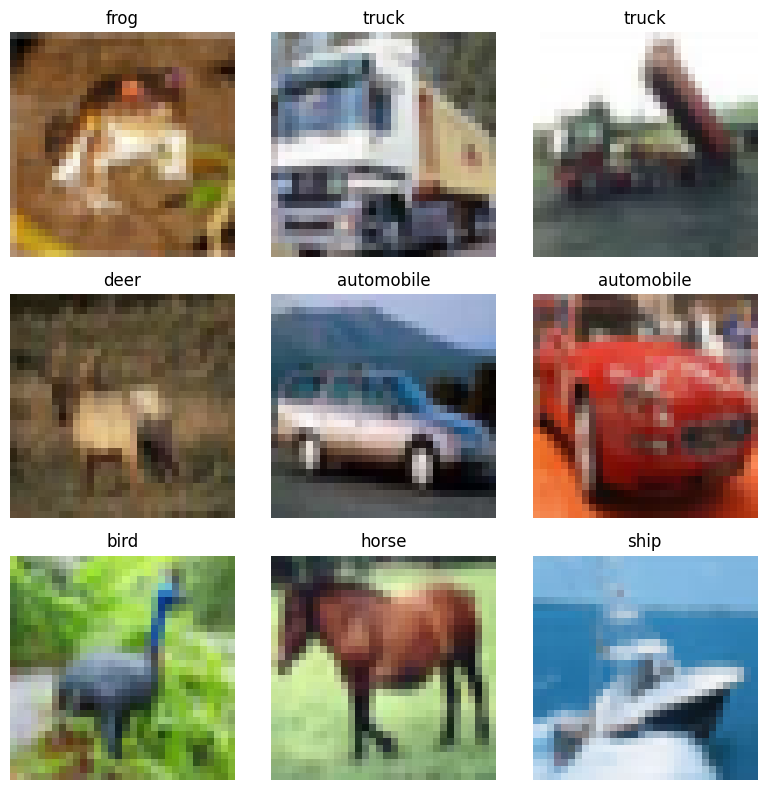

In [7]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [8]:
X_train = X_train.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0


In [9]:
model_1 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       921,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,914 (3.52 MB)

 Trainable params: 923,914 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_1 = model_1.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.3509 - loss: 1.8139 - val_accuracy: 0.4892 - val_loss: 1.4444
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5320 - loss: 1.3162 - val_accuracy: 0.5587 - val_loss: 1.2656
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5915 - loss: 1.1726 - val_accuracy: 0.5855 - val_loss: 1.2102
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6223 - loss: 1.0836 - val_accuracy: 0.5962 - val_loss: 1.1485
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6514 - loss: 0.9986 - val_accuracy: 0.6182 - val_loss: 1.1066
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6659 - loss: 0.9506 - val_accuracy: 0.5708 - val_loss: 1.2634
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6843 - loss: 0.9131 - val_accuracy: 0.6289 - val_loss: 1.0778
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7027 - loss: 0.8599 - val_accuracy: 0.

In [11]:
test_loss, test_acc = model_1.evaluate(X_test, y_test_cat)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6349 - loss: 1.0653
Test accuracy: 0.6355000138282776
Test loss: 1.078613519668579


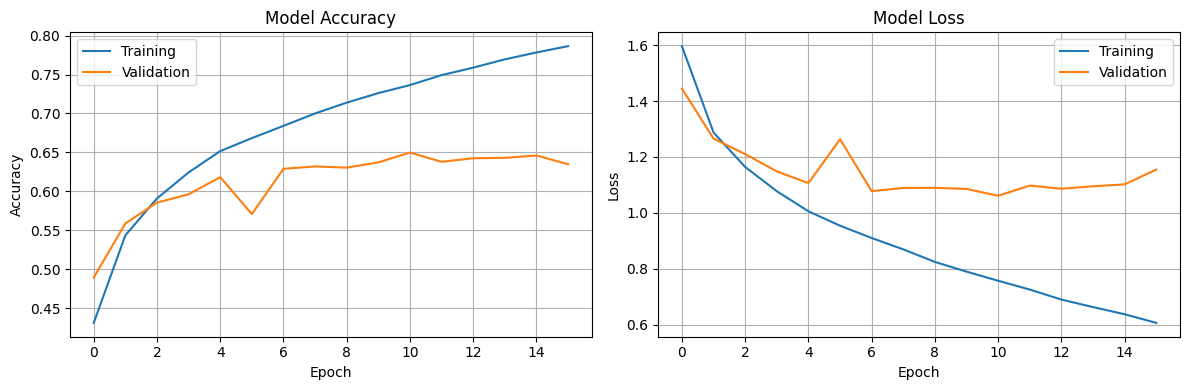

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Training')
plt.plot(history_1.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Training')
plt.plot(history_1.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Deep Model


In [14]:
model_2 = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,994 (1.82 MB)

 Trainable params: 477,994 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history_2 = model_2.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2838 - loss: 1.9146 - val_accuracy: 0.4870 - val_loss: 1.4110
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5066 - loss: 1.3699 - val_accuracy: 0.5977 - val_loss: 1.1323
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5824 - loss: 1.1766 - val_accuracy: 0.6410 - val_loss: 1.0276
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6305 - loss: 1.0449 - val_accuracy: 0.6909 - val_loss: 0.8900
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6568 - loss: 0.9659 - val_accuracy: 0.7003 - val_loss: 0.8345
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6853 - loss: 0.8917 - val_accuracy: 0.7181 - val_loss: 0.7995
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7053 - loss: 0.8422 - val_accuracy: 0.7223 - val_loss: 0.7865
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7186 - loss: 0.8067 - val_accuracy: 0

In [30]:
test_loss, test_acc = model_2.evaluate(X_test, y_test_cat)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7301 - loss: 0.7555
Test accuracy: 0.724399983882904
Test loss: 0.7760862112045288


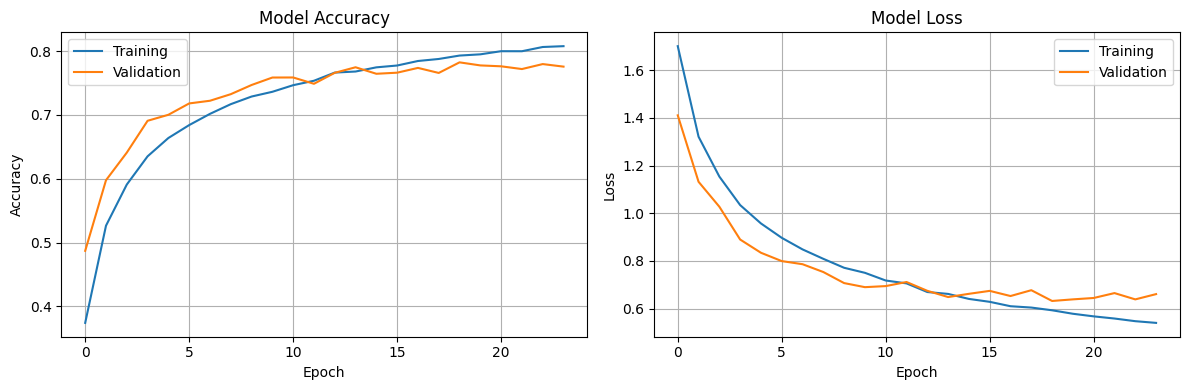

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Training')
plt.plot(history_2.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Training')
plt.plot(history_2.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Batch Normalization

In [24]:

model_3 = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', input_shape=(32,32,3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.0005)

model_3.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_3.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 176,298 (688.66 KB)

 Trainable params: 175,658 (686.16 KB)

 Non-trainable params: 640 (2.50 KB)

In [25]:
history_3 = model_3.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.3149 - loss: 1.8496 - val_accuracy: 0.3973 - val_loss: 1.6706
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5151 - loss: 1.3316 - val_accuracy: 0.4534 - val_loss: 1.4744
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5759 - loss: 1.1700 - val_accuracy: 0.4640 - val_loss: 1.5232
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6153 - loss: 1.0656 - val_accuracy: 0.5799 - val_loss: 1.1530
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6431 - loss: 1.0019 - val_accuracy: 0.6171 - val_loss: 1.0455
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6559 - loss: 0.9654 - val_accuracy: 0.6125 - val_loss: 1.0845
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6695 - loss: 0.9224 - val_accuracy: 0.6382 - val_loss: 1.0240
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6859 - loss: 0.8864 - val_accuracy: 0

In [31]:
test_loss, test_acc = model_3.evaluate(X_test, y_test_cat)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7420 - loss: 0.7310
Test accuracy: 0.7444000244140625
Test loss: 0.7299846410751343


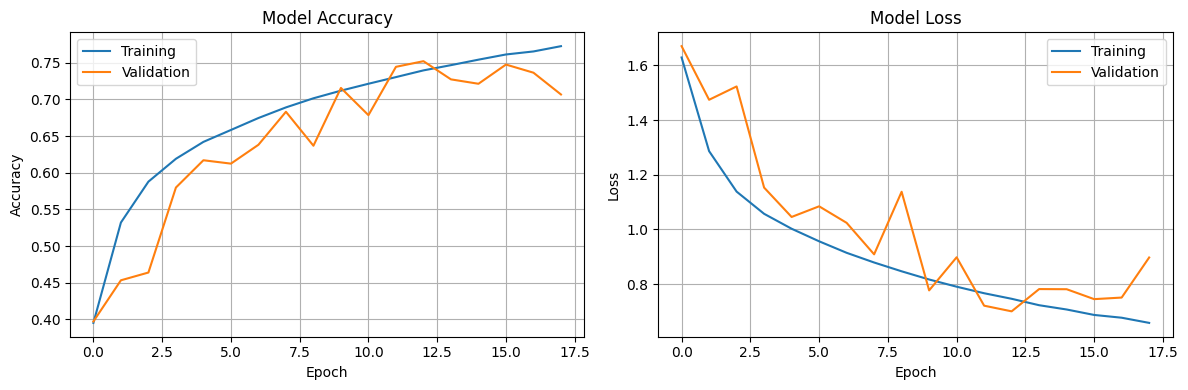

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'], label='Training')
plt.plot(history_3.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'], label='Training')
plt.plot(history_3.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
loss_1, acc_1 = model_1.evaluate(X_test, y_test_cat, verbose=0)
loss_2, acc_2 = model_2.evaluate(X_test, y_test_cat, verbose=0)
loss_3, acc_3 = model_3.evaluate(X_test, y_test_cat, verbose=0)

print(f"Model 1 Accuracy: {acc_1:.4f}")
print(f"Model 2 Accuracy: {acc_2:.4f}")
print(f"Model 3 Accuracy: {acc_3:.4f}")


Model 1 Accuracy: 0.6355
Model 2 Accuracy: 0.7244
Model 3 Accuracy: 0.7444


# VGG LIKE

Data argumentation

In [37]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


In [39]:
vgg_like = models.Sequential([

    # Block 1
    layers.Conv2D(32, (3,3), padding='same', activation='relu',
                  input_shape=(32,32,3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    # Clasificador
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.0005)

vgg_like.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_like.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,341,226 (5.12 MB)

 Trainable params: 1,341,226 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_vgg = vgg_like.fit(
    datagen.flow(X_train, y_train_cat, batch_size=64),
    epochs=50,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.8269 - loss: 0.4942 - val_accuracy: 0.8460 - val_loss: 0.4739
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8318 - loss: 0.4801 - val_accuracy: 0.8290 - val_loss: 0.5419
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8299 - loss: 0.4928 - val_accuracy: 0.8392 - val_loss: 0.4905
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.8337 - loss: 0.4802 - val_accuracy: 0.8452 - val_loss: 0.4634
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.8366 - loss: 0.4694 - val_accuracy: 0.8484 - val_loss: 0.4513
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8329 - loss: 0.4818 - val_accuracy: 0.8372 - val_loss: 0.5126
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8389 - loss: 0.4642 - val_accuracy: 0.8324 - val_loss: 0.5371
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.8378 - loss: 0.4722 - 

In [42]:
test_loss, test_acc = vgg_like.evaluate(X_test, y_test_cat)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8600 - loss: 0.4187
Test accuracy: 0.8569999933242798
Test loss: 0.42026370763778687


# Learning tranfer inceptionv3

In [57]:
IMG_SIZE = 96

X_train_resized = tf.image.resize(X_train, (IMG_SIZE, IMG_SIZE))
X_test_resized = tf.image.resize(X_test, (IMG_SIZE, IMG_SIZE))


In [58]:
X_train_inc = preprocess_input(X_train_resized)
X_test_inc = preprocess_input(X_test_resized)


In [59]:
# Load InceptionV3 base model
base_model = InceptionV3(
    input_shape=(96, 96, 3),   # valid (minimum is 75x75)
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False


model_inception = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Pool spatial features into a vector
    layers.Dense(128, activation='relu'), # Fully connected layer to learn new patterns
    layers.Dense(10, activation='softmax') # Output layer with 10 classes (Fashion MNIST)
])


In [60]:
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3)
]


In [62]:
history_inception = model_inception.fit(
    X_train_inc,
    y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=callbacks
)
test_loss, test_acc = model_inception.evaluate(X_test_inc, y_test_cat)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)



Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - accuracy: 0.2549 - loss: 2.0583 - val_accuracy: 0.3656 - val_loss: 1.7987 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3814 - loss: 1.7573 - val_accuracy: 0.3956 - val_loss: 1.7006 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4057 - loss: 1.6932 - val_accuracy: 0.4077 - val_loss: 1.7033 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4191 - loss: 1.6543 - val_accuracy: 0.3989 - val_loss: 1.6999 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4307 - loss: 1.6260 - val_accuracy: 0.4283 - val_loss: 1.6232 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4380 - loss: 1.5981 - val_accuracy: 0.4370 - val_loss: 1.5959 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4418 - loss: 1

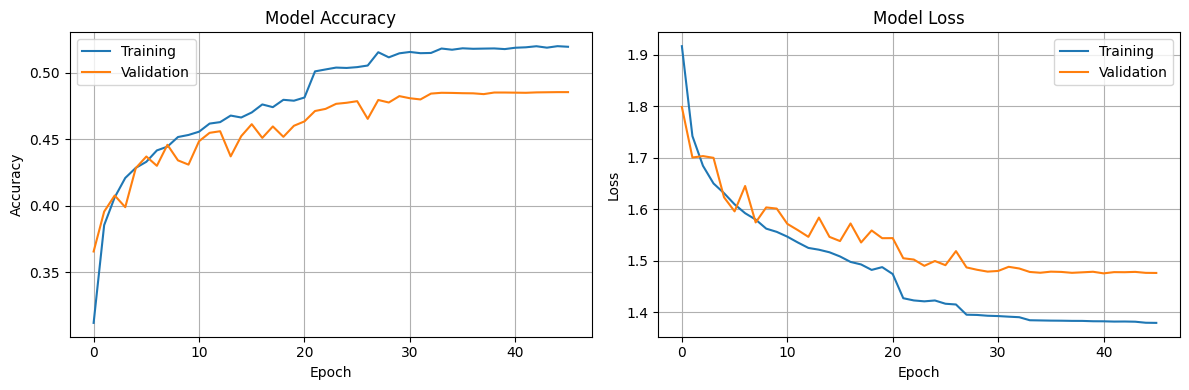

In [63]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_inception.history['accuracy'], label='Training')
plt.plot(history_inception.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_inception.history['loss'], label='Training')
plt.plot(history_inception.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The initial model performed adequately as an experimental baseline, achieving an accuracy of 69.39%. However, its performance confirms that simply reusing a pretrained model without additional adjustments is insufficient for more demanding classification tasks, thereby justifying the need to apply improvement techniques such as data augmentation, classifier optimization, and fine-tuning of the base model.


In [ ]:
y_pred = model_inception.predict(X_test_inc)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


# Improve model using data argument

In [64]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

IMG_SIZE = 128

X_train_resized = tf.image.resize(X_train, (IMG_SIZE, IMG_SIZE))
X_test_resized = tf.image.resize(X_test, (IMG_SIZE, IMG_SIZE))

X_train_inc = preprocess_input(X_train_resized)
X_test_inc = preprocess_input(X_test_resized)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])


base_model = InceptionV3(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False



model_inception_1= models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation='softmax')
])




In [65]:
model_inception_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [67]:
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.3)
]

history_inception_1  = model_inception_1.fit(
    X_train_inc,
    y_train_cat,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=callbacks
)
test_loss, test_acc = model_inception_1.evaluate(X_test_inc, y_test_cat)
print("Test accuracy:", test_acc)



Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.5899 - loss: 1.1576 - val_accuracy: 0.7573 - val_loss: 0.7004 - learning_rate: 9.0000e-05
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.5947 - loss: 1.1668 - val_accuracy: 0.7586 - val_loss: 0.6971 - learning_rate: 9.0000e-05
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5979 - loss: 1.1567 - val_accuracy: 0.7533 - val_loss: 0.7078 - learning_rate: 9.0000e-05
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5911 - loss: 1.1654 - val_accuracy: 0.7627 - val_loss: 0.6902 - learning_rate: 9.0000e-05
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5931 - loss: 1.1579 - val_accuracy: 0.7608 - val_loss: 0.6876 - learning_rate: 9.0000e-05
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5915 - loss: 1.1573 - val_accuracy: 0.7600 - val_loss: 0.6950 - learning_rate: 9.0000e-05
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/ste

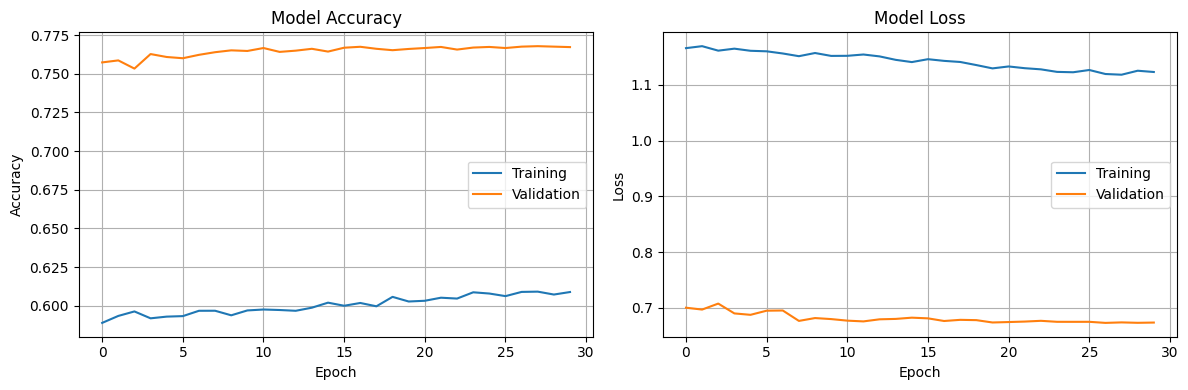

In [68]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_inception_1.history['accuracy'], label='Training')
plt.plot(history_inception_1.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_inception_1.history['loss'], label='Training')
plt.plot(history_inception_1.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# FROZEEN

In [69]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False


In [70]:
model_inception_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_inception_1_1 = model_inception_1.fit(
    X_train_inc,
    y_train_cat,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)
test_loss, test_acc = model_inception_1.evaluate(X_test_inc, y_test_cat)
print("Test accuracy:", test_acc)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.5649 - loss: 1.2561 - val_accuracy: 0.7829 - val_loss: 0.6269 - learning_rate: 1.0000e-04
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.6327 - loss: 1.0520 - val_accuracy: 0.8008 - val_loss: 0.5686 - learning_rate: 1.0000e-04
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.6654 - loss: 0.9640 - val_accuracy: 0.8064 - val_loss: 0.5510 - learning_rate: 1.0000e-04
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.6858 - loss: 0.9010 - val_accuracy: 0.8069 - val_loss: 0.5655 - learning_rate: 1.0000e-04
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7012 - loss: 0.8623 - val_accuracy: 0.8186 - val_loss: 0.5295 - learning_rate: 1.0000e-04
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7209 - loss: 0.8117 - val_accuracy: 0.8176 - val_loss: 0.5365 - learning_rate: 1.0000e-04
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/ste

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_inception_1_1.history['accuracy'], label='Training')
plt.plot(history_inception_1_1.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_inception_1_1.history['loss'], label='Training')
plt.plot(history_inception_1_1.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()